## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(2)


## Create some global parameters
p.c = mf.ModelSymbol(value = 0.15,string = 'c') # chord of wing

p.m = mf.ModelSymbol(value = 1,string = 'm')
p.m_w = mf.ModelSymbol(value = 4,string = 'm_w')
p.s = mf.ModelSymbol(value = 1,string = 's') # chord of wing

p.k = (2*2*sym.pi)**2*(p.m_w+p.m)
p.I_xx = 0#sym.Rational(1,12)*p.m*p.s**2*1

p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda')
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = 1.2,string = 'M_thetadot')

p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot


## FWTD Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')


## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of wing
## FWT Specific
p.a = p.a_0 - p.a_0/p.s*p.y_0

p.alpha_fwt = mf.ModelSymbol(value = 0,string = 'alpha_1') # FWT alpha
p.alphadot_fwt = mf.ModelSymbol(value = 0,string = 'alphadot_1') # FWT alphadot

#### Create Transforms

In [3]:
#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().Translate(0,0,p.q[0]).R_x(-p.q[1])
wing_aero_frame = wing_root_frame.Translate(0,p.y_0,0)
wing_com_frame = wing_root_frame.Translate(0,p.s/2,0)

#Create Elemnts
M_fwt = ele.MassMatrix(p.m,I_xx = p.I_xx)

M_innerWing = ele.RigidElement.PointMass(wing_root_frame,p.m_w,True)
fwt_ele = ele.RigidElement(wing_com_frame,M_fwt,True)
spring_ele = ele.Spring(p.q[0],p.k)


# Create AeroForces
wing_AeroForces = ef.AeroForce_2.PerUnitSpan(p,wing_aero_frame,p.a,
                               alphadot = p.alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = 0,
                               rootAlpha = p.alpha_fwt,
                               alpha_zero = 0)#.integrate((p.y_0,0,p.s))

# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda,p.q[1])

## Sub in Aero Forces
wing_AeroForces = wing_AeroForces.subs({p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})

forces = [wing_AeroForces]
forces = []
segments = 5
for i in range(segments):
    seg_width = p.s/segments
    yi = seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_0:yi})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
c_forces = ef.ExternalForce(Q)

In [4]:
sm = mf.SymbolicModel.FromElementsAndForces(p,[M_innerWing,fwt_ele,spring_ele],c_forces)

# Setup Numeric Model Parameters


In [5]:
tmax, dt = 5, 0.01

p.V.value = 35
p.alpha_r.value = np.deg2rad(5)

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

nm = sm.CreateNumericModel(p)

def objectiveDeriv(t,y):
    deriv = nm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [6]:
sym.trigsimp((wing_aero_frame.BodyJacobian(p.q)*p.qd)[2])

In [7]:
nm.deriv(0,[0,0,np.pi/2,0],p.GetNumericTuple([0,0,0,0],0))

In [8]:
yData = solve_ivp(objectiveDeriv,(0,tmax),[0,0,0,0])

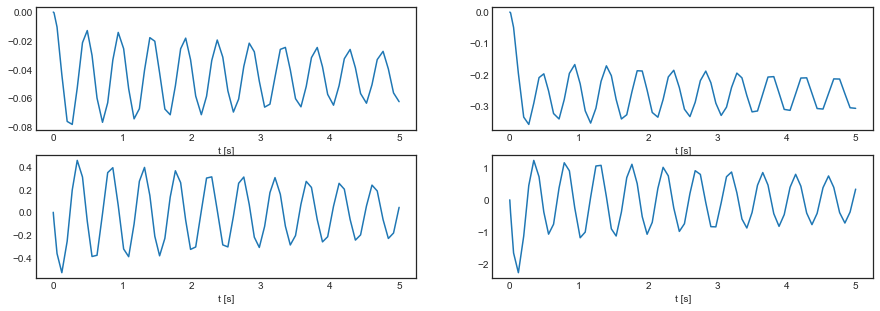

In [9]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

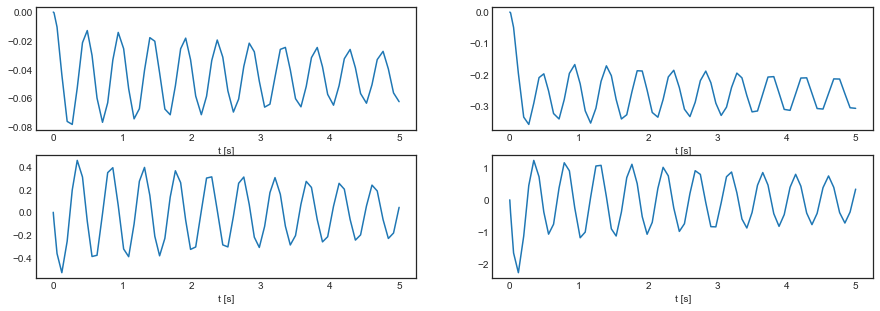

In [10]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

## Create the linearised EoM about some Stationary point

In [11]:
ignores = [p.Lambda,p.V]
# Linearise the Symbolic model# Linearise the Symbolic model
p.fp.value = [0,0,0,0]

# get the linearised sm
sm_lin = sm.linearise(p)

# sub in all but velocity
sm_reduced = sm_lin.subs(p.GetSubs(0,p.fp,ignore=[p.V,p.fp]))

# get eigen Matrices and turn into a function
K,M = sm_reduced.GeneralEigenProblem(p)
K_free,M_free= sm_reduced.FreeBodyEigenProblem(p)

gen_func = sym.lambdify((ignores+[p.fp]),(K,M),'numpy')
free_func = sym.lambdify((ignores+[p.fp]),(K_free,M_free),'numpy')

In [12]:
from scipy.linalg import eig
p.V.value = 0.1
values = tuple([i.value for i in ignores])
eig(*free_func(*values,[0,0,np.pi/2,0]))

(array([0.+12.56637061j, 0.-12.56637061j, 0. +4.42944692j, 0. -4.42944692j]),
 array([[ 0.00000000e+00+7.93266968e-02j,  0.00000000e+00-7.93266968e-02j,
          0.00000000e+00+1.91308041e-19j,  0.00000000e+00-1.91308041e-19j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-2.20219448e-01j,  0.00000000e+00+2.20219448e-01j],
        [-9.96848672e-01+0.00000000e+00j, -9.96848672e-01+0.00000000e+00j,
         -8.47388814e-19+0.00000000e+00j, -8.47388814e-19+0.00000000e+00j],
        [-1.22078754e-16+0.00000000e+00j, -1.22078754e-16+0.00000000e+00j,
          9.75450355e-01+0.00000000e+00j,  9.75450355e-01-0.00000000e+00j]]))

In [36]:
%%timeit -n 10 -r 1 
eig(*gen_func(*values,[0,0,np.pi/2,0]))

309 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [14]:
f = (sm.f-sm.ExtForces.Q()).subs({i:0 for i in p.qd}).subs(p.GetSubs(0,[0]*p.qs*2,ignore=ignores))
func_obj = sym.lambdify((p.q,ignores),f)
func_jac_obj = sym.lambdify((p.q,ignores),f.jacobian(p.q))

In [15]:
from scipy.optimize import fsolve
p.V.value = 0
values = tuple([i.value for i in ignores])
func_obj([np.pi/2,-0.061],values)
fsolve(lambda q,v: func_obj(q,values)[:,0],[np.pi/2,0],fprime = func_jac_obj ,factor = 1,args=(values,))

array([-6.21225507e-02,  2.48028740e+03])

In [16]:
# set fixed variables
#p.ratio_fwt.value = 0.1

#create dict of variations
vars_ls =[]
#vars_ls.append((p.m_1,np.array([0.5,1,1.5,2])*(p.rho_t.value*p.c.value*p.s_t.value*p.ratio_fwt.value)))
vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
#vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
vars_ls.append((p.V,np.linspace(0,150,151))) # ensure velocity last so that fixed points iterats up the velocity
#generate fixed points

#create an array of all possible permutations
perms = np.array(np.meshgrid(*[v for k,v in vars_ls ])).T.reshape(-1,len(vars_ls))

#put in pandas array
df = pd.DataFrame(data = perms, columns=[k.name for k,v in vars_ls])
df['q']=list
df = df.sort_values(by=[k.name for k,v in vars_ls]).reset_index()

In [21]:
from scipy.optimize import fsolve
from scipy.linalg import eig
## Find fixed point for each use case
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for i in range(len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]
    
    #set the initial guess (if v=0 set to FWT dropped doen else use previous result)
    if p.V.value == 0:
        q_guess = [0]*p.qs
        q_guess[-1] = np.pi/2
    else:
        q_guess = df.at[i-1,'q'][::2]
    values = tuple([i.value for i in ignores])
    qf = fsolve(lambda q,v: func_obj(q,values)[:,0],q_guess,fprime = func_jac_obj ,factor = 1,args=(values,))
    #print(f'{np.round(q_guess[-1],2)},{np.round(qf[-1],2)},{p.V.value}')
    #save result
    yf = [0]*p.qs*2  
    yf[::2] = qf
    df.at[i,'q'] = yf

In [22]:
#Calc freqs and dampings
flutdfv2 = pd.DataFrame() 
for i in range(0,len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]

    q = df.at[i,'q']
    
    values = tuple([i.value for i in ignores])
    if p.V.value == 0:
        evals, evecs = eig(*free_func(*values,q))
    else:
        evals, evecs = eig(*gen_func(*values,q))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data
    for k,v in vars_ls:
        jac_dat[k.name] = k.value
        
    # populate fixed point data
    y = np.array(q)
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True) 

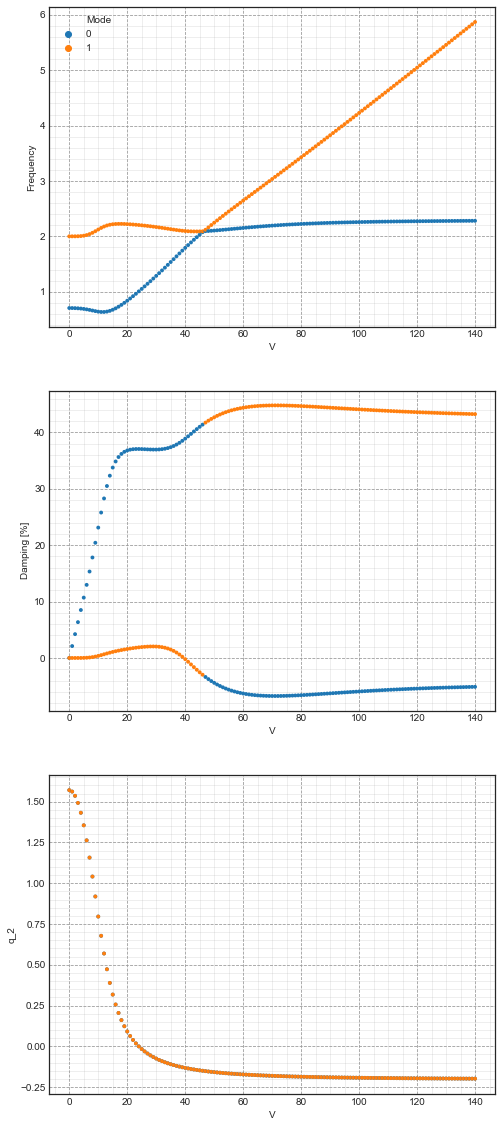

In [37]:
data = flutdfv2.copy()
data = data[data['Lambda']==np.deg2rad(25)]
#data = data[data['alpha_r']==np.deg2rad(0)]
#data = data[data['m_1']>40]
#data = data[data['m_1']<50]
data = data[data['V']<=140]
data['Damping [%]'] = data['Damping']*-100
#print(data[['V','q_12']].head(50))
#data = flutdfv2
fig, axes = plt.subplots(3,1,figsize=(8,20))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue='Mode',ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y=f'q_{(p.qs*2)-2}',hue='Mode',ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,25))
#axes[1].set(ylim=(-20,20))

In [38]:
flutdfv2.to_pickle('Test.pkl')